## measuring latency of the memory Hierarchy

## Import modules

In [1]:
# Enable automatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
!rm -rf logs stats.txt

In [3]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

## Keeping the notebook neat
* Code in notebook is usually linear, one damn line after another.
* Better for modularity to define functions and classes.
* Better for readability to keep large functions in separate python files.

In [4]:
import sys
sys.path.append('./lib')
from measureRandomAccess import measureRandomAccess
from PlotTime import PlotTime
from create_file import create_file,tee

### If you have a doc_string for your methods, 
You can retrieve it by putting `?` after the method name

`create_file?`

### In any case, you can load the code into a cell

`%load lib/create_file.py`

### And you can write chose back in 
After you make changes, you can store it back using the magic

`%%writefile lib/create_file.py`

## setting parameters
* We test access to arrays whose size is a multiple of 1MB. `n` is the block size.
* `m_list` defines the size of the arrays we test, in multiples of block-size.
* `k` defines the number of memory accesses.

In [8]:
n=1000000 # size of single block (1MB)
m_list=[1,10,100,1000,10000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print 'n=%d, k=%d, m_list='%(n,k),m_list

n=1000000, k=100000, m_list= [1, 10, 100, 1000, 10000]


## Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [9]:
%cd /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/0.MemoryLatency
!rm -rf logs stats.txt

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/0.MemoryLatency


In [10]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print line
    stat.write(line+'\n')

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/0.MemoryLatency/logs/1491460420


In [11]:
mean=zeros([2,L])   #0: using disk, 1: using memory
std=zeros([2,L])
T=zeros([2,L,k])

In [12]:
Random_pokes=[]
for m_i in range(len(m_list)):
    
    m=m_list[m_i]
    (t_mem,t_disk) = create_file(n,m,filename='BlockData'+str(m))

    (mean[0,m_i],std[0,m_i],T[0,m_i]) = measureRandomAccess(n*m,filename='BlockData'+str(m),k=k)
    T[0,m_i]=sorted(T[0,m_i])
    tee('\rFile pokes mean='+str(mean[0,m_i])+', file std='+str(std[0,m_i]))

    (mean[1,m_i],std[1,m_i],T[1,m_i]) = measureRandomAccess(n*m,k=k)
    T[1,m_i]=sorted(T[1,m_i])
    tee('\rMemory pokes mean='+str(mean[1,m_i])+', Memory std='+str(std[1,m_i]))
    
    Random_pokes.append({'m_i':m_i,
                        'm':m,
                        'memory_mean': mean[1,m_i],
                        'memory_std': std[1,m_i],
                        'memory_largest': T[1,m_i][-1000:],
                        'file_mean': mean[0,m_i],
                        'file_std': std[0,m_i],
                        'file_largest': T[0,m_i][-1000:]                
                })

              
creating 1000000 byte block: 0.000577 sec, writing 1 blocks 0.010756 sec
File pokes mean=7.25742578506e-06, file std=5.83033115339e-06
Memory pokes mean=2.13206529617e-06, Memory std=2.92550912185e-06
              
creating 1000000 byte block: 0.000036 sec, writing 10 blocks 0.056241 sec
File pokes mean=7.76344299316e-06, file std=7.41394598312e-06
Memory pokes mean=2.04149723053e-06, Memory std=2.15247924027e-06
              
creating 1000000 byte block: 0.000034 sec, writing 100 blocks 0.237230 sec
File pokes mean=8.18794727325e-06, file std=7.66325940954e-06
Memory pokes mean=2.19935417175e-06, Memory std=2.36714835626e-06
              
creating 1000000 byte block: 0.000044 sec, writing 1000 blocks 2.748007 sec
File pokes mean=3.53570461273e-05, file std=2.46649715059e-05
Memory pokes mean=2.26674795151e-06, Memory std=2.56130078801e-06
                                                                                                        
creating 1000000 byte blo

## Characterize random access to storage

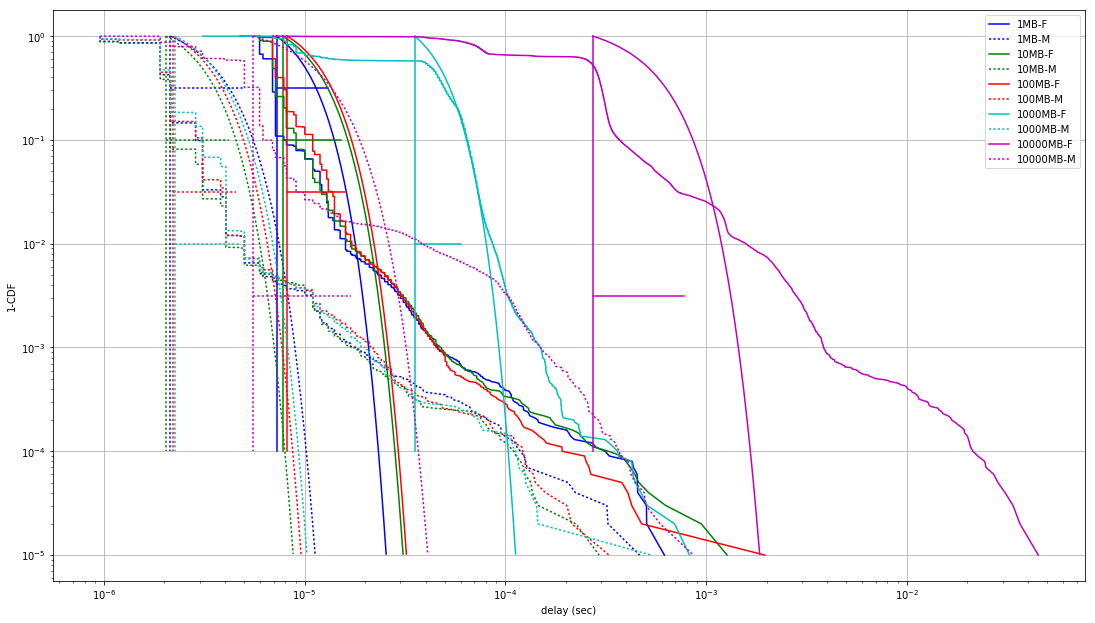

In [13]:
pp = PdfPages('MemoryFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-',':']
Legends=['F','M']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    for Type in [0,1]:
        PlotTime(sort(T[Type,m_i]),mean[Type,m_i],std[Type,m_i],
                 Color=Color,LS=LineStyles[Type],Legend=('%dMB-' % m_list[m_i])+Legends[Type],
                 m_i=m_i)

grid()
legend(fontsize='medium')
xlabel('delay (sec)')
ylabel('1-CDF')
pp.savefig()
pp.close()

## Characterize sequential access

In [14]:
import time
Consec=[]
Line='Consecutive Memory writes'
print Line; stat.write(Line+'\n')
n=1000
r=np.array(range(n))
for m in [1,3,5,7,10,100,1000,10000,100000,1000000]:
    t1=time.time()
    A=np.repeat(r,m)
    t2=time.time()
    Consec.append((n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
    tee("array of length %d repeated %d times. total size=%6.3f MB, Time per element= %g" % (n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
A=[];r=[]
stat.close()

Consecutive Memory writes
array of length 1000 repeated 1 times. total size= 0.001 MB, Time per element= 3.00407e-08
array of length 1000 repeated 3 times. total size= 0.003 MB, Time per element= 1.20004e-08
array of length 1000 repeated 5 times. total size= 0.005 MB, Time per element= 8.7738e-09
array of length 1000 repeated 7 times. total size= 0.007 MB, Time per element= 9.26426e-09
array of length 1000 repeated 10 times. total size= 0.010 MB, Time per element= 5.88894e-09
array of length 1000 repeated 100 times. total size= 0.100 MB, Time per element= 5.00917e-09
array of length 1000 repeated 1000 times. total size= 1.000 MB, Time per element= 5.94497e-09
array of length 1000 repeated 10000 times. total size=10.000 MB, Time per element= 8.20148e-09
array of length 1000 repeated 100000 times. total size=100.000 MB, Time per element= 7.87288e-09
array of length 1000 repeated 1000000 times. total size=1000.000 MB, Time per element= 9.53972e-09


## Observations

* If you write to consecutive locations, you have a per-byte time of around $10^{-8}$ if you jump around you can't do better than $10^{-6}$.
* As you increase the size of the array/file random access speed decreases dramatically, while sequential access speed stays more or less constant.
* The high latency tails are much bigger than what you'd expect from a normal distribution with the same mean and std.

## Impact on Big Data Analytics
* Clock rate is stuck at around 3GHz, and is likely to be stuck there for the forseeable future.
* **Faster** computers / disks / networks are **expensive** 
* The cost-effective solution is often a cluster of many cheap computers, each with many cores and break up the data so that each computer has a small fraction of the data.
* Data-Centers and the "Cloud"

## Logging our results
So that they can be compared to those of others.

In [1]:
%man sysctl

In [2]:
description0= !sysctl kern.osrelease kern.osrevision kern.ostype kern.osversion
description1= !sysctl machdep.cpu.brand_string machdep.cpu.cache.L2_associativity machdep.cpu.cache.linesize machdep.cpu.cache.size machdep.cpu.core_count
description2= !sysctl kern.procname hw.memsize hw.cpufamily hw.activecpu hw.cachelinesize hw.cpufrequency hw.l1dcachesize hw.l1icachesize hw.l2cachesize hw.l3cachesize hw.cputype 

### Directions for TA's

This notebook produces a pkl file with the results of the experiments.
My Requests are:

1. For the description part, add system commands to give details of the machine, especially the sizes of the different caches.
2. Define for the students exactly what they should include in the zip file uploaded: notebook 1 (with a solved excercise) the generated pickle file and the generate pdf file.
3. put a reasonable upper limit on the size of the zip file that they upload.
4. *make sure* that they delete the temporary directory "log" which contains some very large files after the notebook is run.

In [4]:
description=['Brand: Mac Powerbook']+description0+description1+description2
description

['Brand: Mac Powerbook',
 'kern.osrelease: 16.4.0',
 'kern.osrevision: 199506',
 'kern.ostype: Darwin',
 'kern.osversion: 16D32',
 'machdep.cpu.brand_string: Intel(R) Core(TM) i7-3740QM CPU @ 2.70GHz',
 'machdep.cpu.cache.L2_associativity: 8',
 'machdep.cpu.cache.linesize: 64',
 'machdep.cpu.cache.size: 256',
 'machdep.cpu.core_count: 4',
 'kern.procname: sysctl',
 'hw.memsize: 17179869184',
 'hw.cpufamily: 526772277',
 'hw.activecpu: 8',
 'hw.cachelinesize: 64',
 'hw.cpufrequency: 2700000000',
 'hw.l1dcachesize: 32768',
 'hw.l1icachesize: 32768',
 'hw.l2cachesize: 262144',
 'hw.l3cachesize: 6291456',
 'hw.cputype: 7']

In [53]:
%cd ../..

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/0.MemoryLatency


In [57]:
import pickle
with open('memory_report.pkl','wb') as pickle_file:
    pickle.dump({'description':description,
                'Consec':Consec,
                'Random_pokes':Random_pokes},
               pickle_file)

In [58]:
!ls -l

total 1656
-rw-r--r--  1 yoavfreund  staff  259722 Apr  5 22:43 01.1_Row_vs_Col_Major.ipynb
-rw-r--r--  1 yoavfreund  staff    8589 Apr  5 22:34 01.1_Row_vs_Col_Major_MASTER.ipynb
-rw-r--r--  1 yoavfreund  staff   22634 Apr  4 09:16 01_SimpleCount.ipynb
-rw-r--r--  1 yoavfreund  staff   21153 Apr  5 22:33 01_SimpleCount_MASTER.ipynb
-rw-r--r--  1 yoavfreund  staff  227311 Apr  6 09:00 02_measuring_performance_of_memory_hierarchy.ipynb
-rw-r--r--  1 yoavfreund  staff   11544 Apr  5 22:36 02_measuring_performance_of_memory_hierarchy_MASTER.ipynb
drwxr-xr-x  3 yoavfreund  staff     102 Mar 29 17:11 Slides
drwxr-xr-x  8 yoavfreund  staff     272 Apr  5 22:44 lib
drwxr-xr-x  3 yoavfreund  staff     102 Apr  5 23:33 logs
-rw-r--r--  1 yoavfreund  staff  282214 Apr  6 09:00 memory_report.pkl


In [59]:
A=pickle.load(open('memory_report.pkl','r'))

In [65]:
!mv logs/1491460420/MemoryFigure.pdf .

In [66]:
!rm -rf logs

In [67]:
!ls -l

total 1744
-rw-r--r--  1 yoavfreund  staff  259722 Apr  5 22:43 01.1_Row_vs_Col_Major.ipynb
-rw-r--r--  1 yoavfreund  staff    8589 Apr  5 22:34 01.1_Row_vs_Col_Major_MASTER.ipynb
-rw-r--r--  1 yoavfreund  staff   22634 Apr  4 09:16 01_SimpleCount.ipynb
-rw-r--r--  1 yoavfreund  staff   21153 Apr  5 22:33 01_SimpleCount_MASTER.ipynb
-rw-r--r--  1 yoavfreund  staff  224072 Apr  6 09:14 02_measuring_performance_of_memory_hierarchy.ipynb
-rw-r--r--  1 yoavfreund  staff   11544 Apr  5 22:36 02_measuring_performance_of_memory_hierarchy_MASTER.ipynb
-rw-r--r--  1 yoavfreund  staff   48335 Apr  5 23:37 MemoryFigure.pdf
drwxr-xr-x  3 yoavfreund  staff     102 Mar 29 17:11 Slides
drwxr-xr-x  8 yoavfreund  staff     272 Apr  5 22:44 lib
-rw-r--r--  1 yoavfreund  staff  282214 Apr  6 09:00 memory_report.pkl
